In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [4]:
# similar implementation of the stationary scenario
class NonstationaryBernoulliEnvironment:
    def __init__(self, mu, T, seed):
        np.random.seed(seed)
        self.mu = np.array(mu)
        self.rewards = np.random.binomial(n=1, p=self.mu.T)  
        self.K = self.rewards.shape[1]
        self.t = 0  #differently from the stationary environments, it needs to have the time in its state

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

In [5]:
class Learner:
    # this is the blueprint of an Agent-type class, we can customize this with our strategy
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass
      

In [6]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W  #lenght of the window
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

In [7]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0
    
    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                self.n_resets[self.a_t] +=1 
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t 
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False


In [8]:
class UCB1Learner(Learner):
    def __init__(self, K, T):
        self.K = K
        self.T = T
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

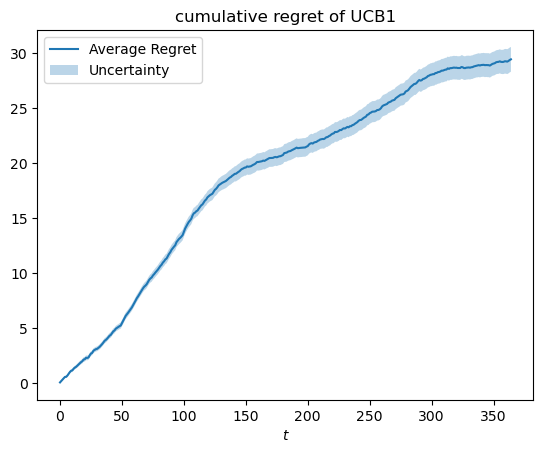

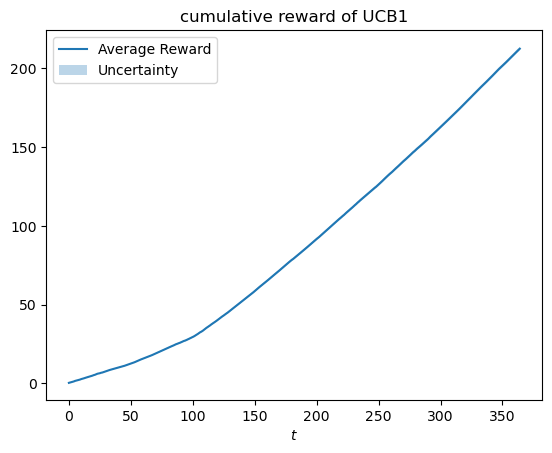

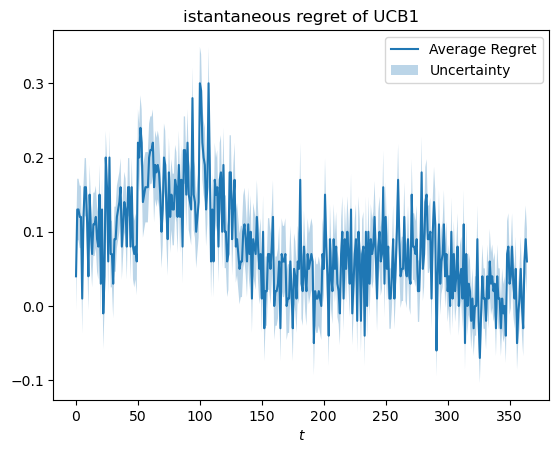

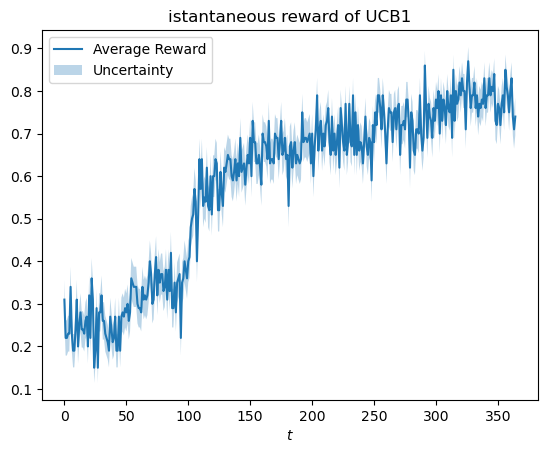

In [15]:
T = 365
mu = ([0.35]*250 + [0.65]*115,
        [0.25]*100 + [0.5]*200 + [0.8]*65,
        [0.2]*150 + [0.7]*150 + [0.75]*65,
        [0.25]*50 + [0.5]*200 + [0.8]*115,
        [0.2]*100 + [0.7]*100 + [0.75]*165
    )
K = len(mu)
U_T = 3 # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U_T)) # assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = UCB1Learner(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    
    cumulative_reward = np.cumsum(agent_rewards)
    reward_per_trial.append(cumulative_reward)
    
    istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
    istantaneous_regret_per_trial.append(istantaneous_regret)

    istantaneous_reward = agent_rewards
    istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of UCB1')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of UCB1')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


C:\Users\ines.hafdaoui\AppData\Local\Temp\ipykernel_1572\3925047978.py:17: RuntimeWarning: Mean of empty slice
  avg_last_w = np.nanmean(self.cache, axis=0)
C:\Users\ines.hafdaoui\AppData\Local\Temp\ipykernel_1572\3925047978.py:18: RuntimeWarning: divide by zero encountered in divide
  ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)


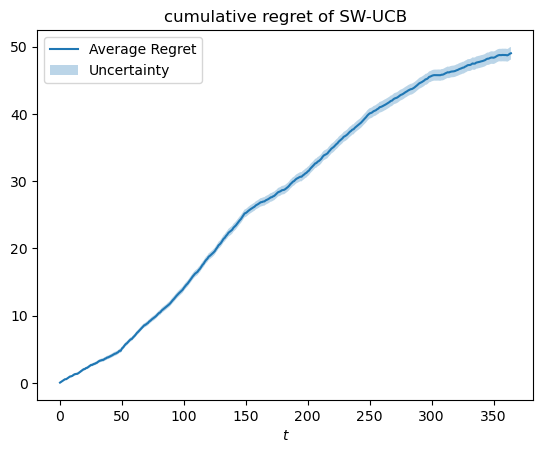

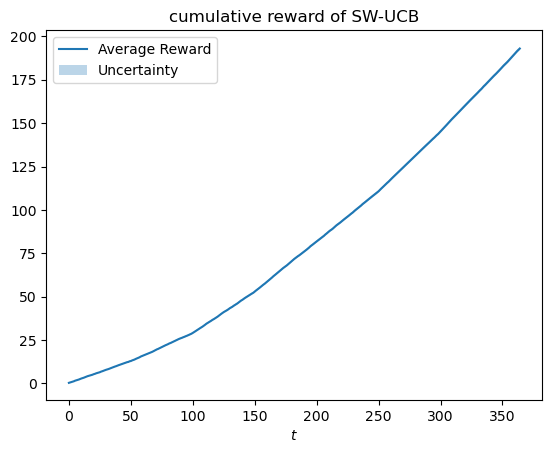

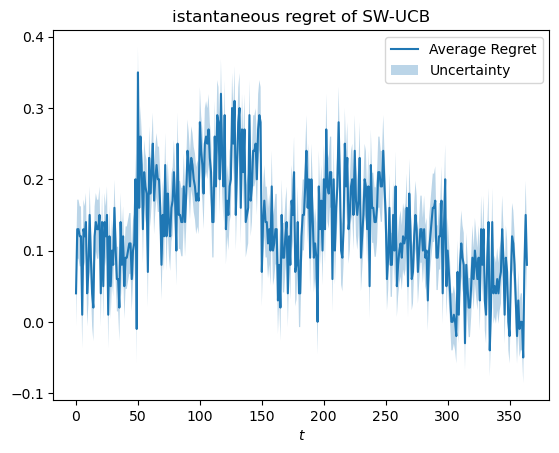

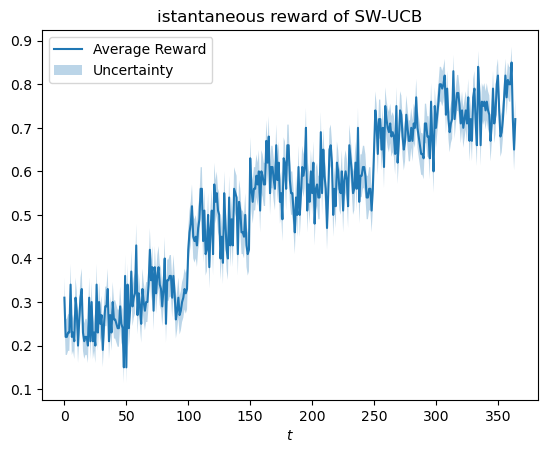

In [24]:
T = 365
mu = ([0.35]*250 + [0.65]*115,
        [0.25]*100 + [0.5]*200 + [0.8]*65,
        [0.2]*150 + [0.7]*150 + [0.75]*65,
        [0.25]*50 + [0.5]*200 + [0.8]*115,
        [0.2]*100 + [0.7]*100 + [0.75]*165
    )
K = len(mu)
U_T = 50 # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U_T)) # assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    
    cumulative_reward = np.cumsum(agent_rewards)
    reward_per_trial.append(cumulative_reward)
    
    istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
    istantaneous_regret_per_trial.append(istantaneous_regret)

    istantaneous_reward = agent_rewards
    istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of SW-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of SW-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


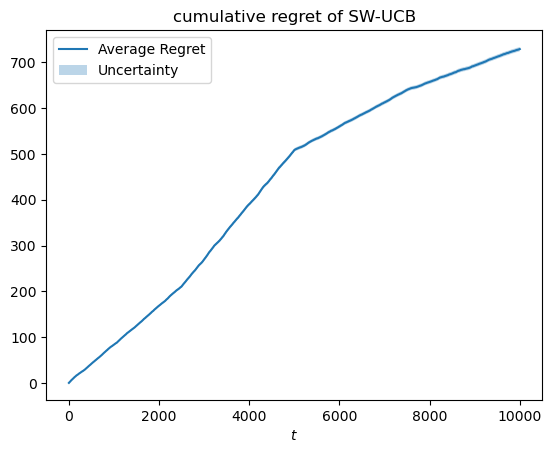

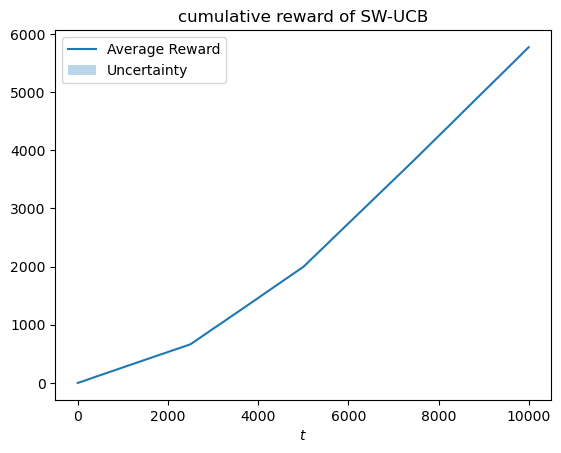

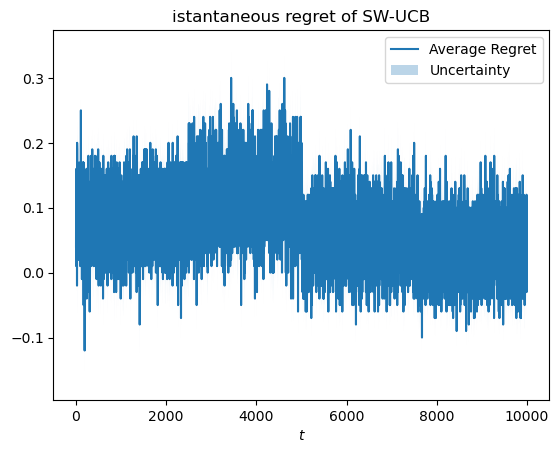

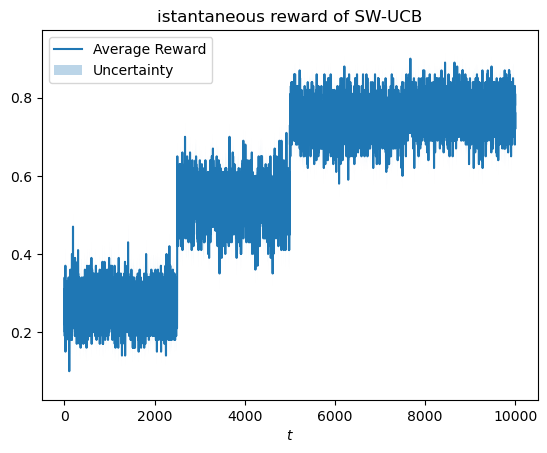

In [26]:
T = 10000  # WE ARE INCREASING THE SLIDING WINDOW LENGHT WRT THE PREVIOUS CASE
mu = ([0.35]*2500 + [0.65]*7500,
        [0.25]*2500 + [0.5]*2500 + [0.8]*5000,
        [0.2]*5000 + [0.7]*2500 + [0.75]*2500,
        [0.25]*2500 + [0.5]*2500 + [0.8]*5000,
        [0.2]*5000 + [0.7]*2500 + [0.75]*2500
    )
K = len(mu)
U_T = 3 # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U_T)) # assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    
    cumulative_reward = np.cumsum(agent_rewards)
    reward_per_trial.append(cumulative_reward)
    
    istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
    istantaneous_regret_per_trial.append(istantaneous_regret)

    istantaneous_reward = agent_rewards
    istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of SW-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of SW-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


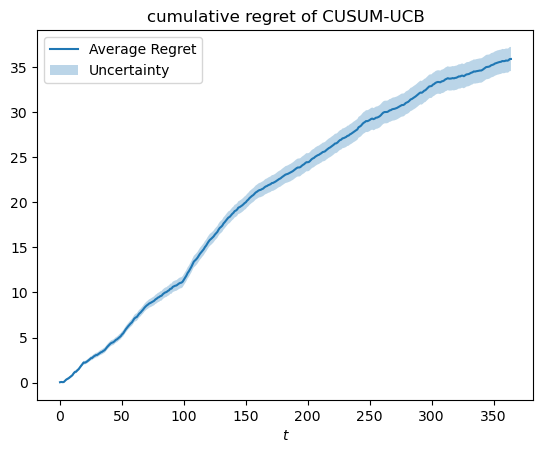

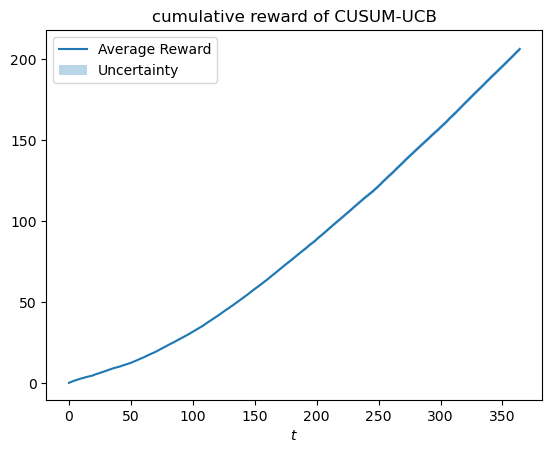

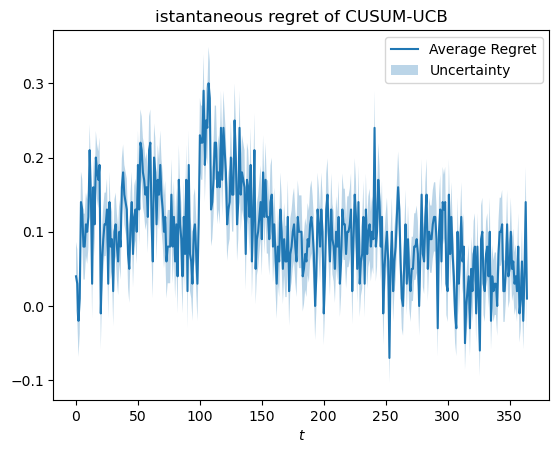

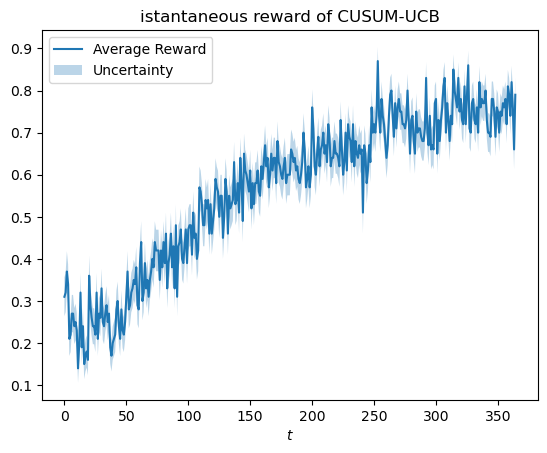

In [19]:
T = 365
mu = ([0.35]*250 + [0.65]*115,
        [0.25]*100 + [0.5]*200 + [0.8]*65,
        [0.2]*150 + [0.7]*150 + [0.75]*65,
        [0.25]*50 + [0.5]*200 + [0.8]*115,
        [0.2]*100 + [0.7]*100 + [0.75]*165
    )

K = len(mu)
U_T = 3 # maximum number of abrupt changes
h = 2*np.log(T/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(T/U_T)/T) # probability of extra exploration

M = int(np.log(T/U_T)) # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    
    cumulative_reward = np.cumsum(agent_rewards)
    reward_per_trial.append(cumulative_reward)
    
    istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
    istantaneous_regret_per_trial.append(istantaneous_regret)

    istantaneous_reward = agent_rewards
    istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()


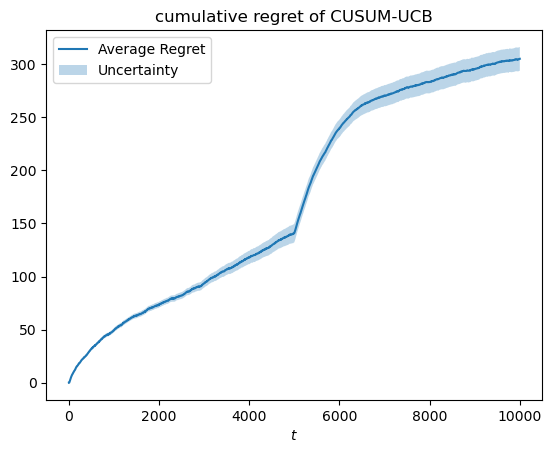

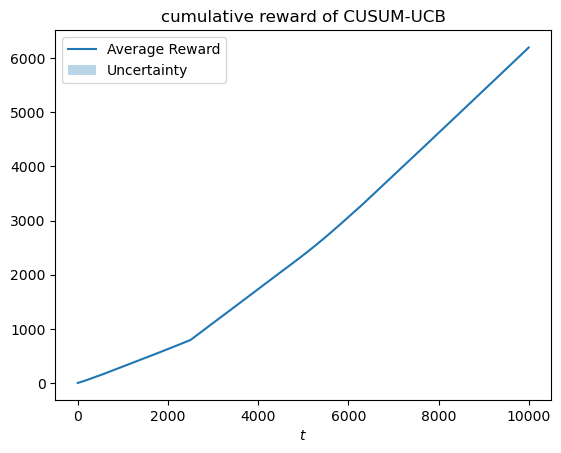

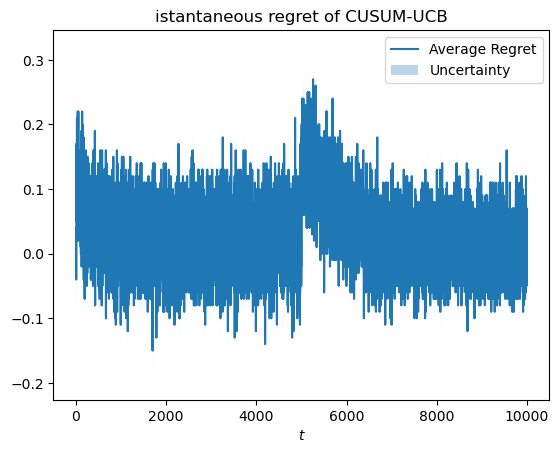

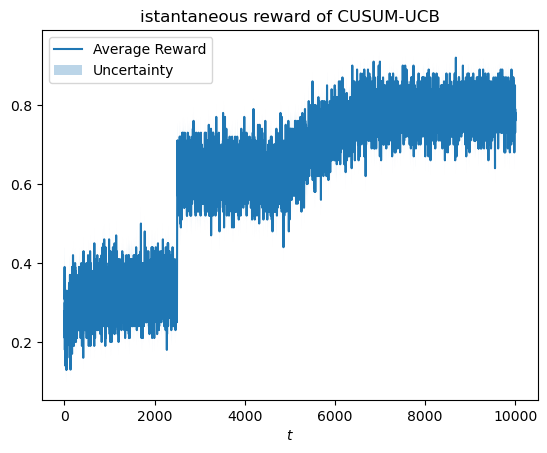

In [27]:
T = 10000  # WE ARE INCREASING THE CHANGE DETECTION PARAMETERS 
mu = ([0.35]*2500 + [0.65]*7500,
        [0.25]*2500 + [0.5]*2500 + [0.8]*5000,
        [0.2]*5000 + [0.7]*2500 + [0.75]*2500,
        [0.25]*2500 + [0.5]*2500 + [0.8]*5000,
        [0.2]*5000 + [0.7]*2500 + [0.75]*2500
    )

K = len(mu)
U_T = 3 # maximum number of abrupt changes
h = 2*np.log(T/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(T/U_T)/T) # probability of extra exploration

M = int(np.log(T/U_T)) # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]

expected_clairvoyant_rewards = np.array(mu).max(axis=0)

n_trials = 100

regret_per_trial = []
reward_per_trial = []
istantaneous_regret_per_trial = []
istantaneous_reward_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, seed)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    
    cumulative_reward = np.cumsum(agent_rewards)
    reward_per_trial.append(cumulative_reward)
    
    istantaneous_regret = expected_clairvoyant_rewards-agent_rewards
    istantaneous_regret_per_trial.append(istantaneous_regret)

    istantaneous_reward = agent_rewards
    istantaneous_reward_per_trial.append(istantaneous_reward)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

reward_per_trial = np.array(reward_per_trial)
average_reward = reward_per_trial.mean(axis=0)
reward_sd = reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('cumulative reward of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_regret_per_trial = np.array(istantaneous_regret_per_trial)
average_regret = istantaneous_regret_per_trial.mean(axis=0)
regret_sd = istantaneous_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('istantaneous regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

istantaneous_reward_per_trial = np.array(istantaneous_reward_per_trial)
average_reward = istantaneous_reward_per_trial.mean(axis=0)
reward_sd = istantaneous_reward_per_trial.std(axis=0)

plt.plot(np.arange(T), average_reward, label='Average Reward')
plt.title('istantaneous reward of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_reward-reward_sd/np.sqrt(n_trials),
                average_reward+reward_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()
